## Intro

This notebook runs bagged sklearn trees on the multi class AG_news dataset

In [15]:
# # # local
project_directory = "../"


# # # # colab
# from google.colab import drive
# drive.mount('/content/drive')
# project_directory = "/content/drive/MyDrive/colab_working_directory/diversity-enforced-ensembles/"
# !pip install cached-property

In [16]:
from pathlib import Path
import pandas as pd
import numpy as np

# allow import of decompose locally
import sys
sys.path.append(project_directory + 'src/')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from decompose import CrossEntropy
import bvdlib
from sklearn.metrics import log_loss

from gensim.models import FastText
from gensim.utils import tokenize

In [17]:
save_path = project_directory + "experiments/results/SKlearn_baggedTree_over_n_members_text_MCCELoss.pkl"

## Pre-Process Data

In [18]:
# get data
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
train_df = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["train"])
test_df = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["test"])

train_labels  = train_df['label'].to_numpy()
test_labels = test_df['label'].to_numpy()

train_df = train_df['text'].to_numpy()
test_df = test_df['text'].to_numpy()

In [19]:
def tokenizedoc(data):
    tokenized_data = []
    for sent in data:
        tokenized_data.append(list(tokenize(sent)))
    return tokenized_data

tokenized_training = tokenizedoc(train_df)
tokenized_testing = tokenizedoc(test_df)

KeyboardInterrupt: 

In [ ]:
model = FastText(vector_size=16, window=3, min_count=1, sentences=tokenized_training, epochs=10, seed=0)

In [ ]:
def gen_sent_vecs(model, token_list):
    sent_vecs = []
    for sent in token_list:
        sent_vecs.append(model.wv.get_sentence_vector(sent))
    return sent_vecs
train_data = np.array(gen_sent_vecs(model, tokenized_training))
test_data = np.array(gen_sent_vecs(model, tokenized_testing))

print("Train data shape", train_data.shape)
print("Test data shape", test_data.shape)

Train data shape (120000, 16)
Test data shape (7600, 16)


In [ ]:
# reduce samples, classes remain roughly balanced
reduced_len_test = 500
reduced_len_train = 4500

test_data = test_data[:reduced_len_test]
test_labels = test_labels[:reduced_len_test]

train_labels = train_labels[:reduced_len_train]
train_data = train_data[:reduced_len_train]

In [ ]:
#define settings

n_trials = 100
trial_space = np.arange(1,21) # Test estimators from 1 to 20
num_training = int(0.8 * len(train_data))

In [ ]:
# seed experiment
experiment_seed = 0
np.random.seed(experiment_seed)

## Run Experiments

In [ ]:
model_function = BaggingClassifier
member_model = DecisionTreeClassifier
decomp_fn = CrossEntropy
loss_fn = log_loss
smoothing_factor = 1e-8
class_num = len(np.unique(train_labels))

# define a trial
def trial_run(trial):

    trial_x, trial_y = trial.get_data

    # init model
    n_estim = trial.get_singular_parameter()
    model = model_function(n_estimators=n_estim, estimator = member_model(criterion="log_loss"))

    model.fit(trial_x, trial_y)


    trial_results_array = np.zeros((n_estim, len(test_data), class_num))

    train_losses = []
    for i, member in enumerate(model.estimators_):
        train_preds = member.predict_proba(trial_x)
        train_losses.append(loss_fn(trial_y, train_preds))
        member_preds = member.predict_proba(test_data)
        trial_results_array[i, :] = member_preds

    trial_results_array = (1 - smoothing_factor) * trial_results_array + smoothing_factor * (np.ones_like(trial_results_array)) * (1. / trial_results_array.shape[-1])

    return trial_results_array, np.mean(train_losses)

    

study = bvdlib.Study(trial_space, train_data, train_labels, test_data, test_labels, 
                     num_training, n_trials, decomp_fn)
results = study.run_trials(trial_run)
results.save_results(save_path)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [20:05<00:00, 60.29s/it] 


<Axes: xlabel='n_estimators'>

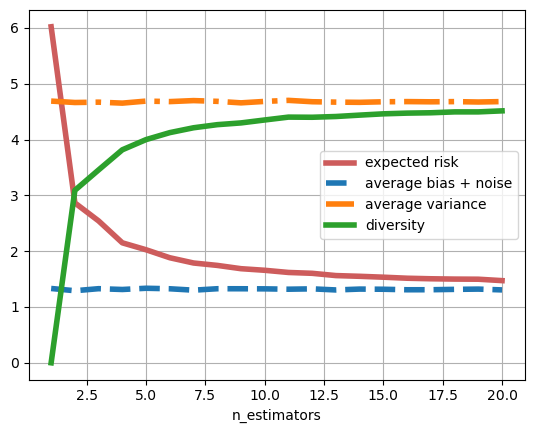

In [20]:
from decompose.plotting_utils import plot_bvd

plot_bvd(results)